https://en.wikipedia.org/wiki/Burn_down_chart

In [42]:
import pandas as pd

import psycopg2
import matplotlib.pyplot as plt
import datetime

In [96]:
# credentials in ~/.pgpass
conn = psycopg2.connect(
    dbname='redmine',
    user='jn',
    host='192.168.1.250',
    port='5432',
)

In [97]:
cursor = conn.cursor()

In [98]:
conn.rollback()

In [101]:
cursor.execute('select count(*) from issues')
cursor.fetchall()

[(20,)]

In [62]:
cursor.execute('''
select
    start_date::date
    , due_date::date
    , case
        when issue_statuses.name in ('Resolved','Feedback','Closed','Rejected')
            then updated_on::date
        else null
    end as completed_date
FROM issues
inner join issue_statuses on(issue_statuses.id=issues.status_id);
''')

In [63]:
headers = [c.name for c in cursor.description]

In [64]:
rows = [dict(zip(headers, r)) for r in cursor]

In [66]:
cursor.execute('select min(start_date) from issues')
earliest_date = cursor.fetchone()[0]

In [67]:
one_day = datetime.timedelta(days=1)

In [68]:
today = datetime.date.today()

In [69]:
num_days = (today - earliest_date).days

In [80]:
cursor.execute('select count(*) from issues')
issue_count = cursor.fetchone()[0]
issue_count

20

In [81]:
days = list()
curr_day = earliest_date
i = 0
while curr_day < today:
    days.append([issue_count, issue_count])
    for row in rows:
        cd = row['completed_date']
        if cd is not None and cd <= curr_day:
            days[i][0] -= 1
        sd = row['start_date']
        if sd is not None and sd <= curr_day:
            days[i][1] -= 1

    curr_day += one_day
    i += 1

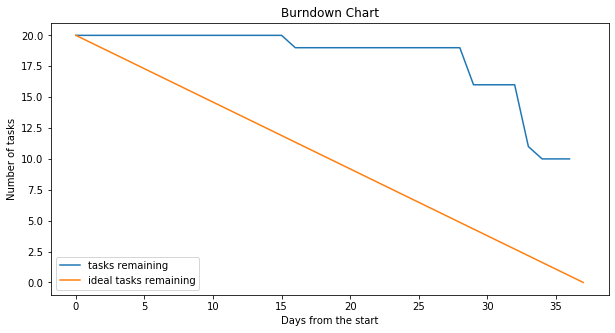

In [95]:
plt.figure(figsize=[10, 5])
plt.title('Burndown Chart')
plt.xlabel('Days from the start')
plt.ylabel('Number of tasks')
_ = plt.plot(range(len(days)), [d[0] for d in days])
plt.plot([0, num_days], [issue_count, 0])
_ = plt.legend(['tasks remaining', 'ideal tasks remaining'])